In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from statsmodels.tsa.stattools import adfuller
from keras.layers import Conv1D, MaxPooling1D, Flatten

In [4]:
df = pd.read_csv("/Users/mohdjunaid/Deep Learning Project 1/dataset.csv")
print("the head of the data is:")
print(df.head())
print("the tail of the data is:")
print(df.tail())

the head of the data is:
         Date      Open      High       Low     Close  Adj Close     Volume
0  1980-12-12  0.128348  0.128906  0.128348  0.128348   0.100178  469033600
1  1980-12-15  0.122210  0.122210  0.121652  0.121652   0.094952  175884800
2  1980-12-16  0.113281  0.113281  0.112723  0.112723   0.087983  105728000
3  1980-12-17  0.115513  0.116071  0.115513  0.115513   0.090160   86441600
4  1980-12-18  0.118862  0.119420  0.118862  0.118862   0.092774   73449600
the tail of the data is:
             Date        Open        High         Low       Close   Adj Close  \
10463  2022-06-13  132.869995  135.199997  131.440002  131.880005  131.880005   
10464  2022-06-14  133.130005  133.889999  131.479996  132.759995  132.759995   
10465  2022-06-15  134.289993  137.339996  132.160004  135.429993  135.429993   
10466  2022-06-16  132.080002  132.389999  129.039993  130.059998  130.059998   
10467  2022-06-17  130.070007  133.080002  129.809998  131.559998  131.559998   

       

In [2]:
!pip install statsmodels


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 7.5 MB/s eta 0:00:00a 0:00:01


In [5]:
# checking for the duplicate values
duplicate_dates = df[df.duplicated(['Date'])]
print("the duplicate dates are:")
print(duplicate_dates)
# checking for the missing values
missing_values = df.isnull().sum()
print("the missing values are:")
print(missing_values)

the duplicate dates are:
Empty DataFrame
Columns: [Date, Open, High, Low, Close, Adj Close, Volume]
Index: []
the missing values are:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [6]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

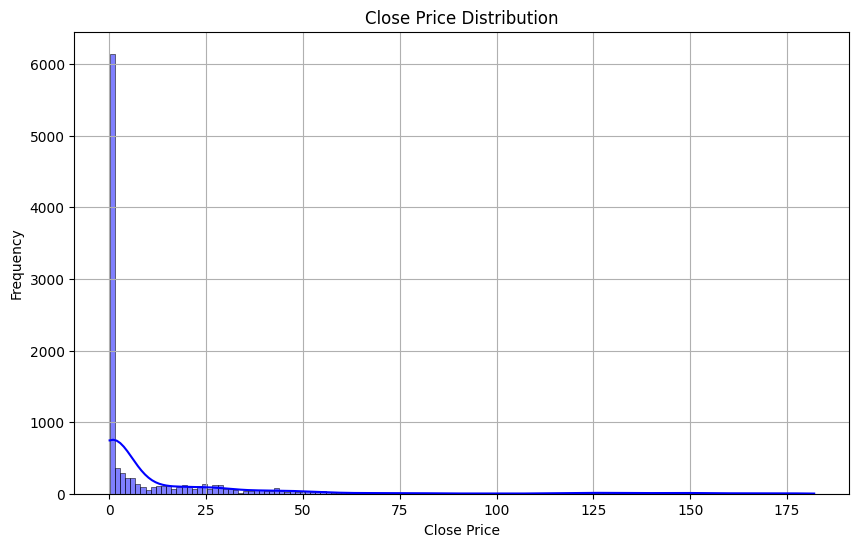

In [7]:
# the ditribution of close price
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.title('Close Price Distribution')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
sns.histplot(df['Close'], kde=True, color='blue')
plt.show()

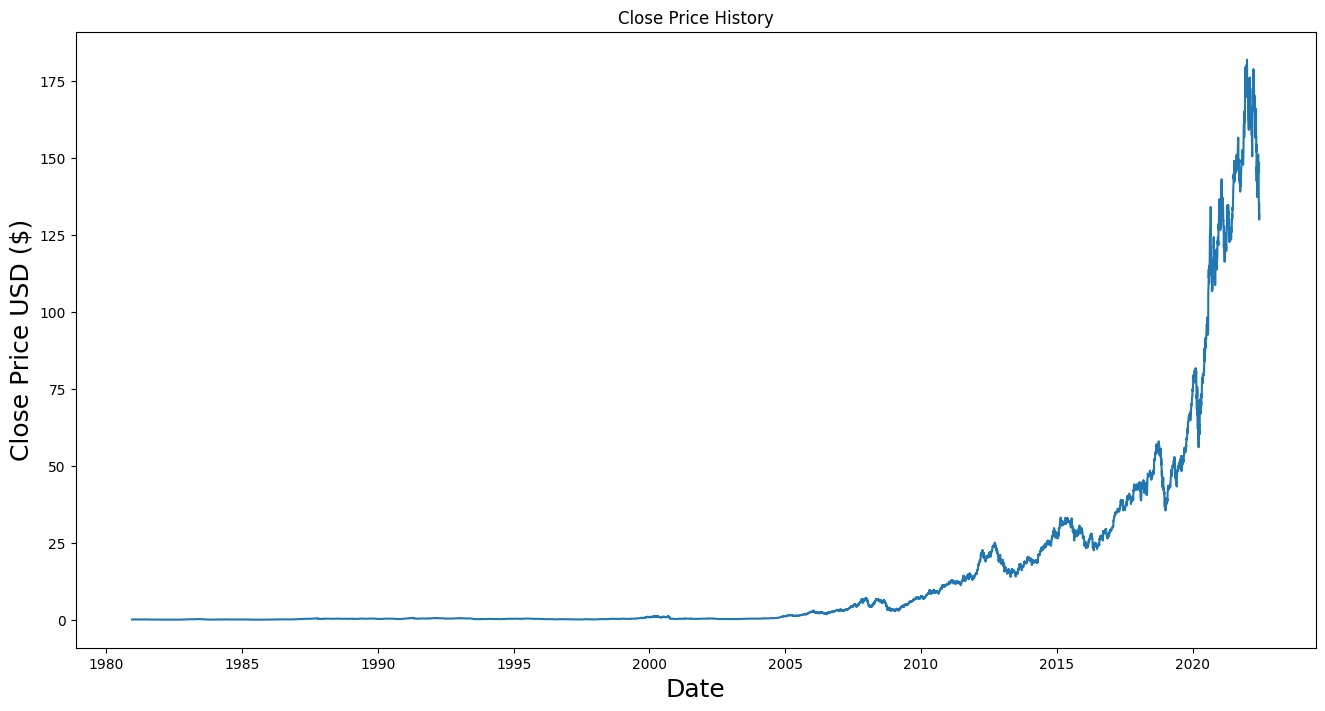

In [8]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

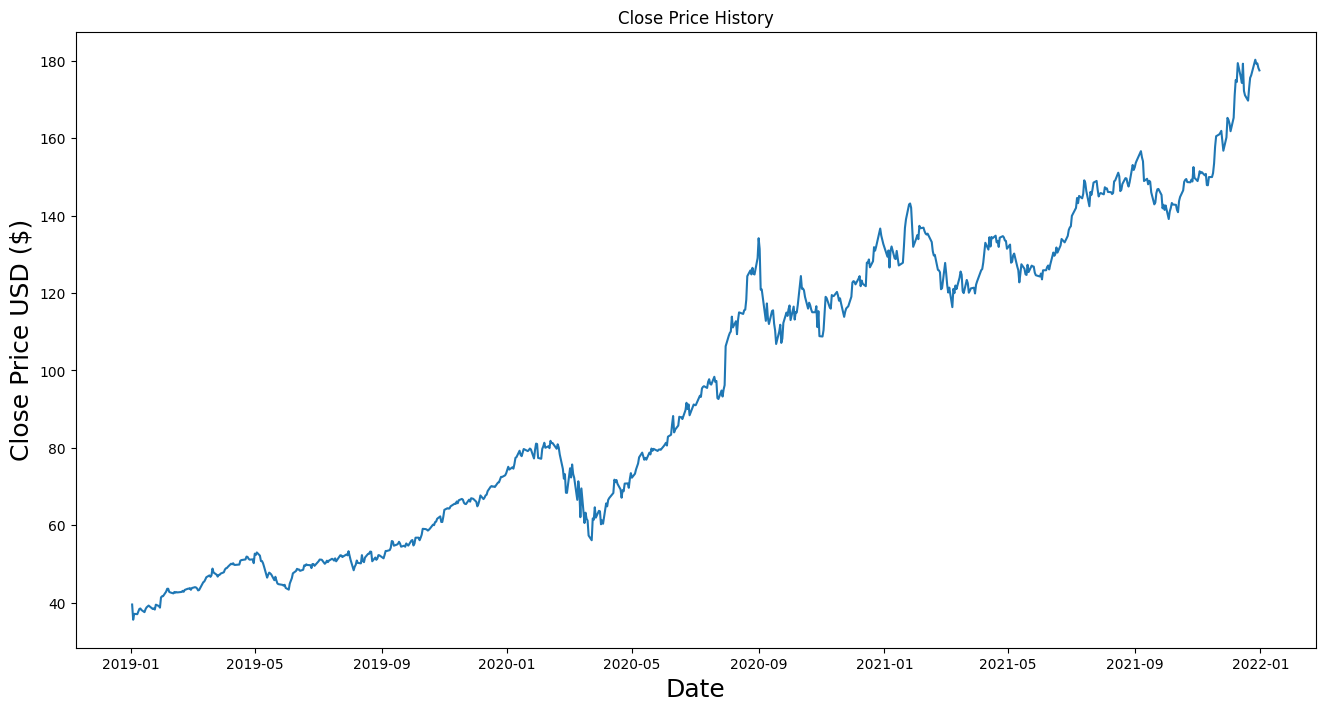

In [9]:
df_2019_2022 = df.loc['2019-01-01':'2022-01-01']
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df_2019_2022['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

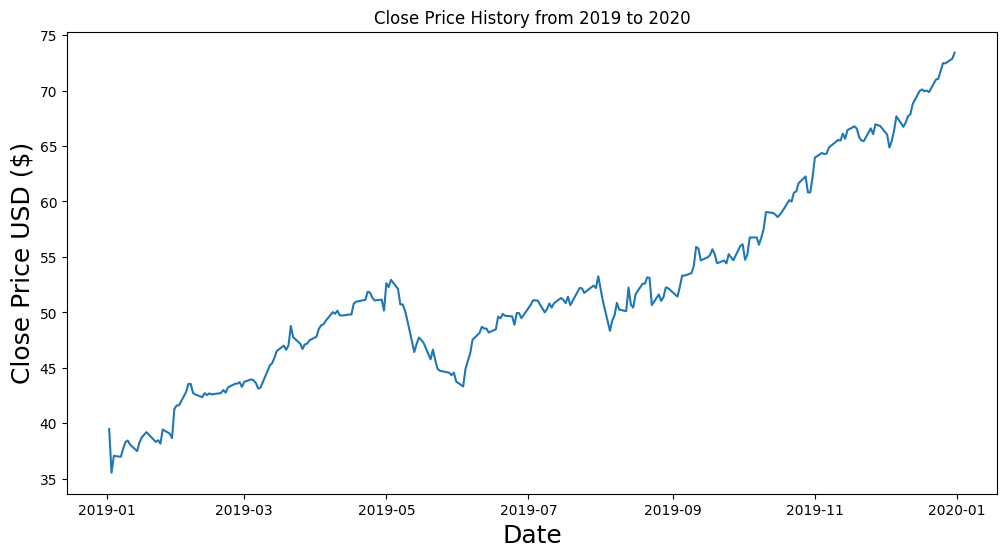

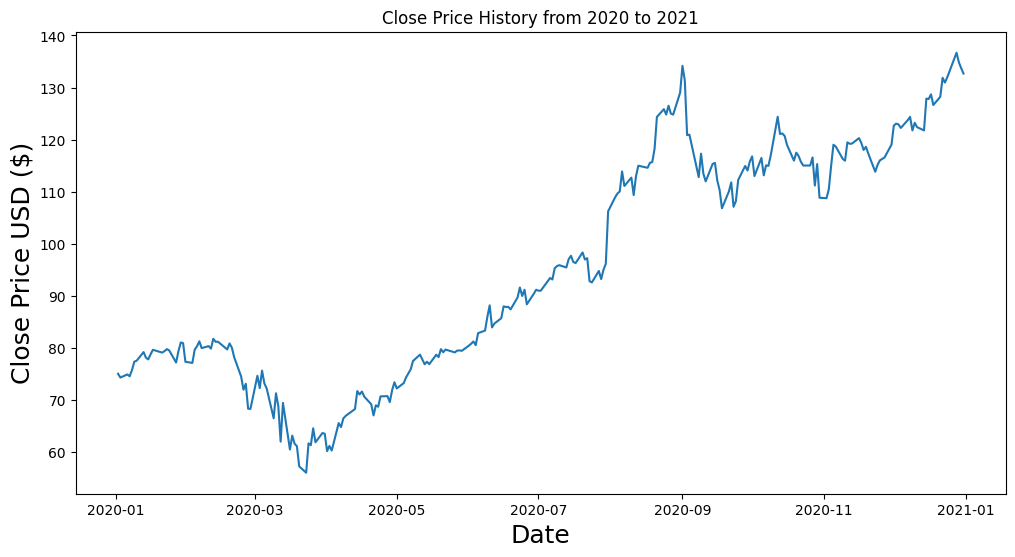

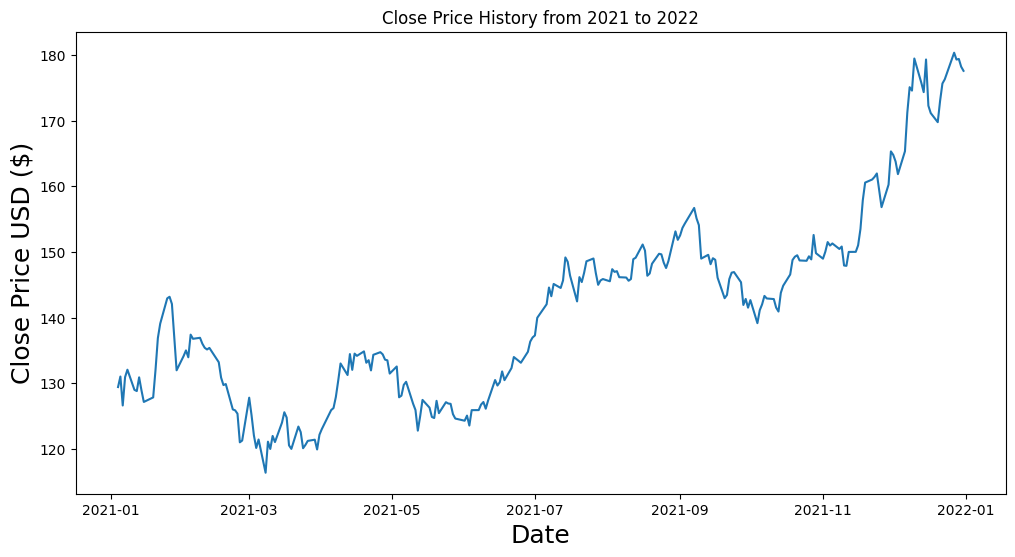

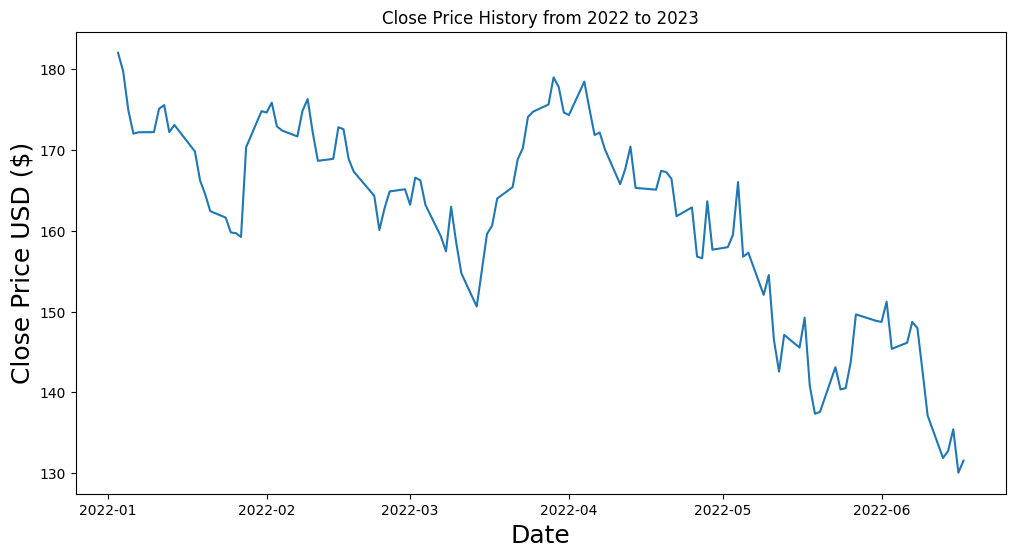

In [10]:
for year in range(2019, 2023):
    df_year = df.loc[str(year)+'-01-01':str(year+1)+'-01-01']
    plt.figure(figsize=(12,6))
    plt.title('Close Price History from '+str(year)+' to '+str(year+1))
    plt.plot(df_year['Close'])
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.show()

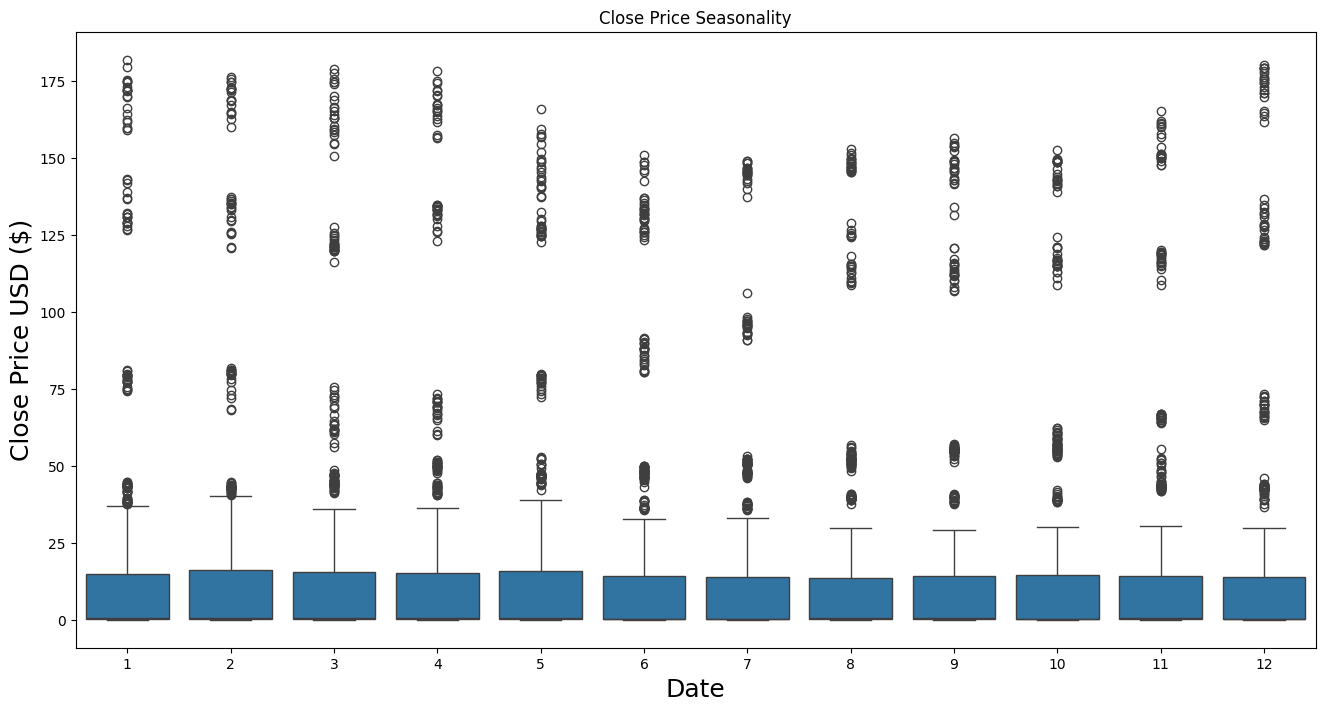

In [11]:
plt.figure(figsize=(16,8))
plt.title('Close Price Seasonality')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
sns.boxplot(data=df, x=df.index.month, y='Close')
plt.show()

In [12]:
def adf_test(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    if dfoutput[1] <= 0.05:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")


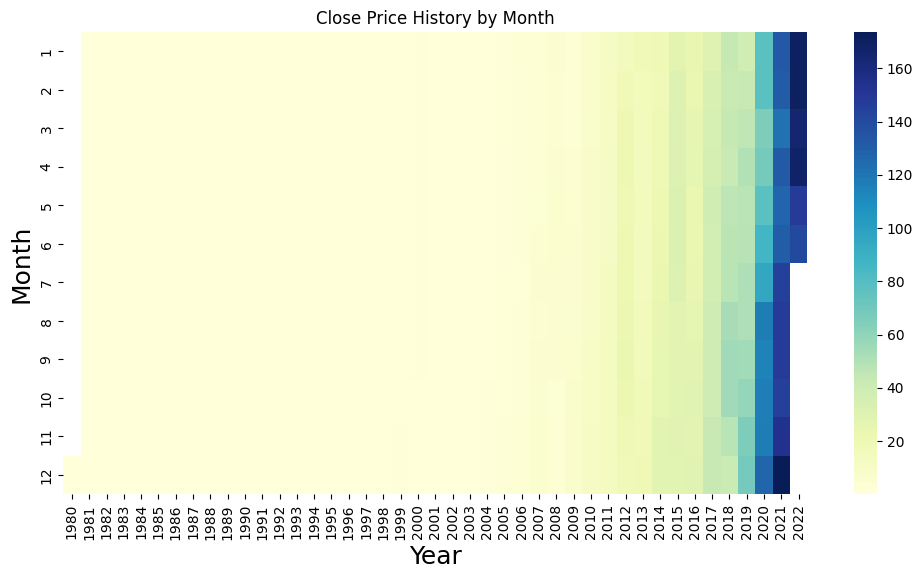

In [13]:
df['Year'] = df.index.year
df['Month'] = df.index.month
df_pivot = df.pivot_table(index='Month', columns='Year', values='Close')
plt.figure(figsize=(12,6))
plt.title('Close Price History by Month')
sns.heatmap(df_pivot, annot=False, cmap='YlGnBu')
plt.xlabel('Year', fontsize=18)
plt.ylabel('Month', fontsize=18)
plt.show()

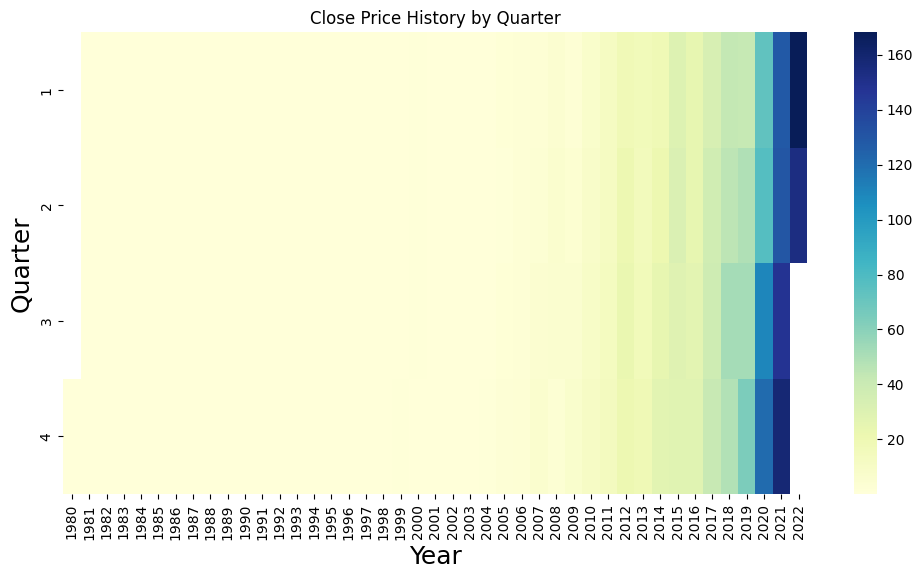

In [14]:
df['Quarter'] = df.index.quarter
df_pivot = df.pivot_table(index='Quarter', columns='Year', values='Close')
plt.figure(figsize=(12,6))
plt.title('Close Price History by Quarter')
sns.heatmap(df_pivot, annot=False, cmap='YlGnBu')
plt.xlabel('Year', fontsize=18)
plt.ylabel('Quarter', fontsize=18)
plt.show()

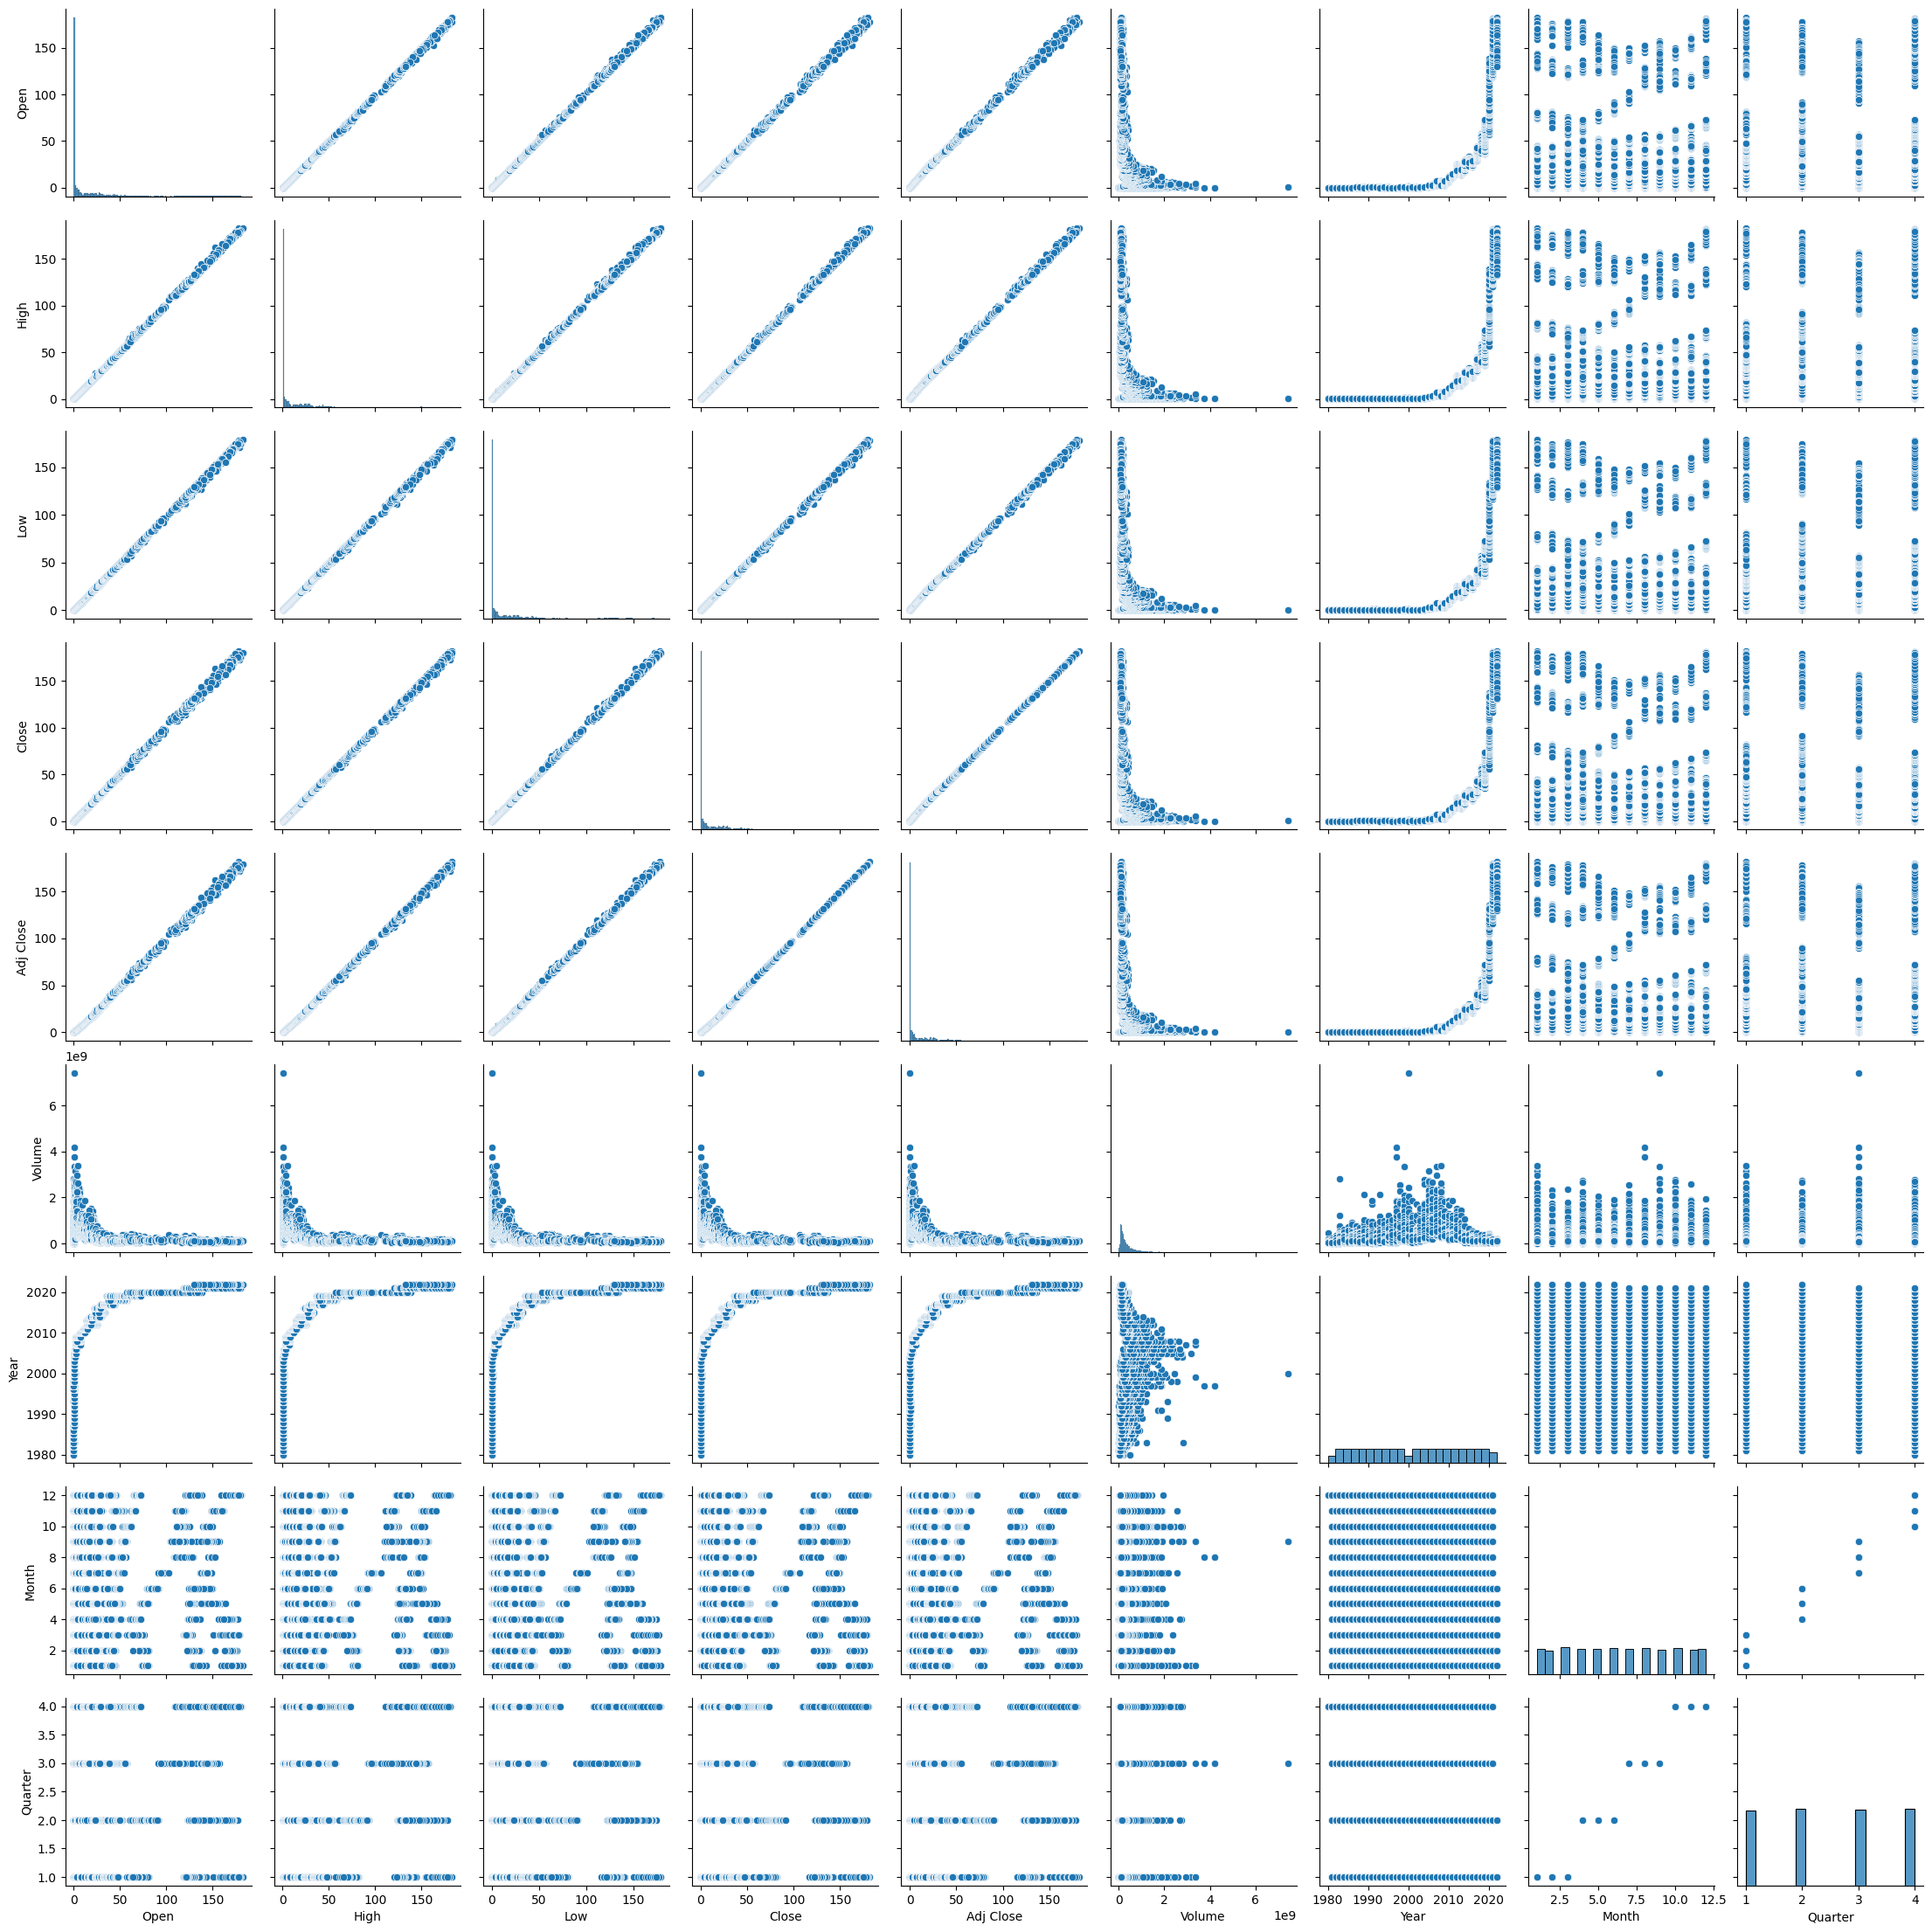

In [15]:
#pairplot
sns.pairplot(df)
plt.show()

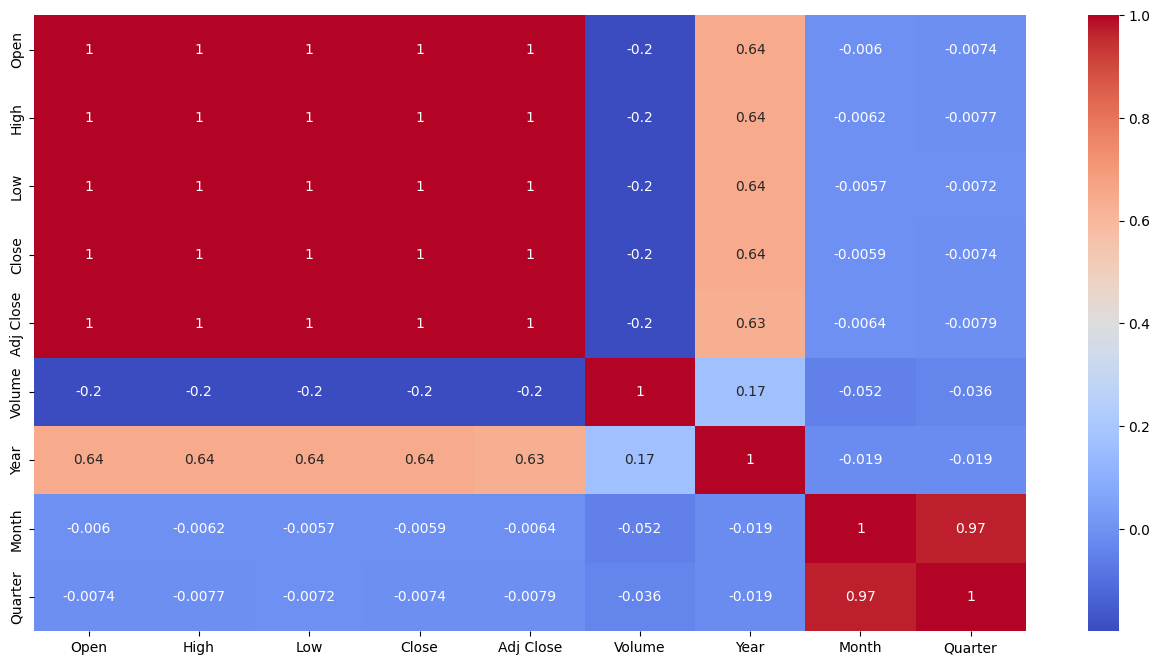

In [16]:
#correlation matrix
plt.figure(figsize=(16,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show() 

In [17]:
X = df[['Open', 'High', 'Low', 'Volume']]
y = df['Close']

In [18]:
# let's scale the data  using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)
y = y.values.reshape(-1,1)

In [19]:
X_train,X_test,y_train,y_test = X[:int(X.shape[0]*0.9)],X[int(X.shape[0]*0.9):],y[:int(X.shape[0]*0.9)],y[int(X.shape[0]*0.9):]

In [29]:
#LSTM with CONV1D
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Conv1D(128, 3, activation='relu'))
#model.add(MaxPooling1D(3))
model.add(Flatten())
model.add(Dense(64))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [30]:
model.fit(X_train, y_train, batch_size=32, epochs=1)

295/295 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 49.9998


In [36]:
predictions = model.predict(X_test)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [34]:
r2_score(y_test, predictions)

0.9083128301166743